In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from src.TimeSeriesLearningUtils import TimeSeriesDataset
from datetime import datetime

In [4]:
def get_data(currency_list,
             data_frequency,
             pred_frequency, 
             num_classes,
             window_size,
             neutral_quantile = 0.33,
             beg_date = pd.Timestamp(2017,1,1),
             end_date = pd.Timestamp.now(),
             log_price = True,
             remove_trend = False,
             decompose = False,
             ma_period = 0,
             indicators = False,
             imfs = False,
             ohlv = False,
              **kwargs):

        X, y, dfs = {}, {}, {}     
        
        for cur in currency_list:
            df = pd.read_csv(f"../data/0_raw/Binance/{str.lower(cur)}_usdt_{data_frequency}.csv", header=None,index_col=0)
            df.index = pd.to_datetime(df.index, unit='ms')
            df.sort_index(inplace=True)
            df.columns = ["open","high","low","close","volume"]
            
            if indicators:
                from ta import add_all_ta_features
                indicators_df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)
                df[indicators_df.columns] = indicators_df
          
            if imfs:
                from PyEMD import EEMD
                eemd = EEMD(parallel=True, processes=2)
                imfs_result = eemd(df["close"].values, max_imf=7)
                imf_features = ["imf_"+str(i) for i in range(imfs_result.shape[0])]
                df = pd.concat((df, pd.DataFrame(imfs_result.T, columns=imf_features, index=df.index)), axis=1)
            
            if log_price:
                df[["close", "open", "high", "low"]] = df[["close", "open", "high", "low"]].apply(np.log, axis=1)
                   
            if num_classes == 3:
                pct_diff = df['close'].pct_change()
                quantile_value = pct_diff.abs().quantile(neutral_quantile).loc[neutral_quantile]
                
                conditions = [(pct_diff < 0) & (pct_diff.abs() > quantile_value),
                              (pct_diff > 0) & (pct_diff.abs() > quantile_value)]

                classes = [0,1] # 2 is the default class if none of conditions is met, i.e. price change in the neutral range
            
                change_dir = np.select(conditions, classes, default=2)
            
            else: 
                change_dir = df['close'].diff().apply(lambda x: 0 if x <= 0 else 1)
            
            df.insert(loc=0, column="change_dir", value=change_dir)   
            
            if remove_trend:
                #from statsmodels.tsa.seasonal import seasonal_decompose
                #ma_period = ma_period if pred_frequency in ['d', 'D'] else ma_period * 4
                #components = seasonal_decompose(df["close"], model="additive", period = ma_period, two_sided=False)
                #df["close"] -= components.trend
                df['diff'] = df['close'].diff()
                #df['diff'] = df['close'].pct_change()
                df.drop('close', axis=1, inplace=True)
                df.dropna(inplace=True) 

            if decompose: 
                from statsmodels.tsa.seasonal import seasonal_decompose
                ma_period = ma_period if pred_frequency in ['d', 'D'] else ma_period * 4 #if pred_frequency is 6h, then multiply the ma_period by 4 
                components = seasonal_decompose(df["close"], model="additive", period = ma_period, two_sided=False)
                df['trend'] = components.trend
                df['residual'] = components.resid  
                df['seasonal'] = components.seasonal
                df.dropna(inplace=True)  

            if not ohlv: #keeping open, high, low, and volume
                df.drop(["open", "high", "low", "volume"], axis=1, inplace=True)

            dfs[cur] = df
        
        min_dates = [df.index.min() for cur, df in dfs.items()]
        max_dates = [df.index.max() for cur, df in dfs.items()]
        beg_date = max([max(min_dates), beg_date])
        end_date = min([min(max_dates), end_date])
        common_range = pd.date_range(beg_date, end_date, freq=pred_frequency)
        
        missing = set()
        common_set = set(common_range)
        for cur, df in dfs.items():
            missing_steps = common_set.difference(df.index)
            missing |= missing_steps
        common_range = common_range.drop(missing)
        
        X = np.array([dfs[cur].loc[common_range].drop(["change_dir"], axis=1).values for cur in currency_list])
        y = np.array([dfs[cur].loc[common_range, "change_dir"].values for cur in currency_list])
        features = df.columns.tolist()
        features.remove("change_dir")

        return X, y, features, dfs, common_range

In [5]:
def get_data2(currency_list,
             data_frequency,
             pred_frequency, 
             num_classes,
             window_size,
             neutral_quantile = 0.33,
             beg_date = pd.Timestamp(2017,1,1),
             end_date = pd.Timestamp.now(),
             log_price = True,
             remove_trend = False,
             ma_period = 0,
             include_indicators = False,
             include_imfs = False,
             ohlv = False,
             drop_missing = True,
              **kwargs):

        X, y, dfs = {}, {}, {}     
        
        for cur in currency_list:
            df = pd.read_csv(f"../data/0_raw/Binance/{str.lower(cur)}_usdt_{data_frequency}.csv", header=None,index_col=0)
            df.index = pd.to_datetime(df.index, unit='ms')
            df.sort_index(inplace=True)
            df.columns = ["open","high","low","close","volume"]
            
            if include_indicators:
                from ta import add_all_ta_features
                indicators_df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)
                df[indicators_df.columns] = indicators_df
            
            if include_imfs:
                from PyEMD import EEMD
                eemd = EEMD(parallel=True, processes=2)
                imfs = eemd(df["close"].values, max_imf=7)
                imf_features = ["imf_"+str(i) for i in range(imfs.shape[0])]
                df = pd.concat((df, pd.DataFrame(imfs.T, columns=imf_features, index=df.index)), axis=1)
            
            if log_price:
                df[["close", "open", "high", "low"]] = df[["close", "open", "high", "low"]].apply(np.log, axis=1)
                   
            if num_classes == 3:
                df['pct_diff'] = df['close'].pct_change()
                neutral_quantiles = df['pct_diff'].abs().quantile(neutral_quantile).loc[neutral_quantile]

                conditions = [(df['pct_diff'] < 0) & (df['pct_diff'].abs() > neutral_quantiles),
                              (df['pct_diff'] > 0) & (df['pct_diff'].abs() > neutral_quantiles)]

                classes = [0,1] # 2 is the default class if none of conditions is met, i.e. price change in the neutral range
            
                change_dir = np.select(conditions, classes, default=2)
            
            else:
                df['diff'] = df['close'].diff()
                change_dir = df['diff'].apply(lambda x: 0 if x <= 0 else 1)
            
            df.insert(loc=0, column="change_dir", value=change_dir)   
            df.dropna(inplace=True)  
            
            if remove_trend:
                from statsmodels.tsa.seasonal import seasonal_decompose
                components = seasonal_decompose(df["close"].values, period=3, model="additive")#, period = ma_period, two_sided=False)
                df["close"] -= components.trend
                df.dropna(inplace=True)
                
            if not ohlv: #keeping open, high, low, and volume
                df.drop(["open", "high", "low", "volume"], axis=1, inplace=True)

            dfs[cur] = df
        
        min_dates = [df.index.min() for cur, df in dfs.items()]
        max_dates = [df.index.max() for cur, df in dfs.items()]
        beg_date = max([max(min_dates), beg_date])
        end_date = min([min(max_dates), end_date])
        common_range = pd.date_range(beg_date, end_date, freq=pred_frequency)
        
        missing = set()
        common_set = set(common_range)
        for cur, df in dfs.items():
            missing_steps = common_set.difference(df.index)
            missing |= missing_steps
        common_range = common_range.drop(missing)
        
        diff_col = 'pct_diff' if num_classes == 3 else 'diff'

        X = np.array([dfs[cur].loc[common_range].drop(["change_dir", diff_col], axis=1).values for cur in currency_list])
        y = np.array([dfs[cur].loc[common_range, "change_dir"].values for cur in currency_list])
        features = df.columns.tolist()
        features.remove("change_dir")
        
        return X, y, features, dfs, common_range

In [6]:
CURRENCY_LST = ['BTC', 'ETH', 'LTC', 'XRP', 'ADA']
num_classes = 2
FREQUENCY = "d"
WINDOW_SIZE = 400
NEUTRAL_QUANTILE = 0.33,
dataset_percentages = [0.90, 0.05, 0.05]
train_pct = 0.8
LOOK_AHEAD = 3

In [7]:
X, y, features, dfs, common_range = get_data(currency_list= CURRENCY_LST,
                               data_frequency='1d',
                               pred_frequency=FREQUENCY,
                               num_classes = num_classes, 
                               window_size = WINDOW_SIZE,
                               neutral_quantile = NEUTRAL_QUANTILE,
                               log_price = True,
                               remove_trend = True,
                               ma_period = 7,
                               indicators = False,
                               imfs = False,
                               decompose = False,
                               ohlv = False,
                               beg_date = pd.Timestamp(2017,1,1),
                               end_date = pd.Timestamp(2022,1,1))

In [8]:
X.shape

(5, 1197, 1)

In [9]:
df = dfs['BTC']
df.describe()

,change_dir,diff
count,1460.000000,1460.000000
mean,0.530822,0.001648
std,0.499220,0.043587
min,0.000000,-0.502607
25%,0.000000,-0.015750
50%,1.000000,0.001810
75%,1.000000,0.019939
max,1.000000,0.202952


In [10]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier

In [12]:
LOOK_AHEAD=6
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]
    
    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    lr = LogisticRegression()
    lr.fit(X_train[:-LOOK_AHEAD], y_train[LOOK_AHEAD:])
    print(cur)
    #print(lr.coef_)
    print(lr.score(X_train[:-LOOK_AHEAD], y_train[LOOK_AHEAD:]))
    print(lr.score(X_test[:-LOOK_AHEAD], y_test[LOOK_AHEAD:]))

BTC
0.9984152139461173
0.8501805054151624
ETH
1.0
0.8483754512635379
LTC
0.9857369255150554
0.8537906137184116
XRP
0.9667194928684627
0.8393501805054152
ADA
0.9841521394611727
0.8375451263537906


In [13]:
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]

    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    print(cur)
    #print(lr.coef_)
    print(lr.score(X_train, y_train))
    print(lr.score(X_test, y_test))

BTC
0.9937205651491365
0.8678571428571429
ETH
1.0
0.8517857142857143
LTC
0.9858712715855573
0.8553571428571428
XRP
0.9811616954474097
0.85
ADA
0.9968602825745683
0.8589285714285714


In [14]:
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]
    
    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
    rf.fit(X_train, y_train)
    print(cur)
    print(rf.score(X_train, y_train))
    print(rf.score(X_test, y_test))

BTC
1.0
0.8714285714285714
ETH
1.0
0.8607142857142858
LTC
1.0
0.8571428571428571
XRP
1.0
0.8642857142857143
ADA
1.0
0.8696428571428572


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

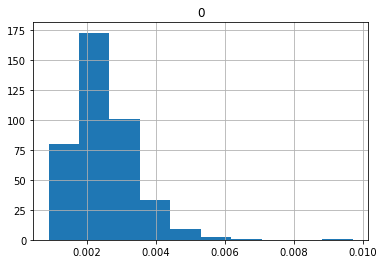

In [15]:
pd.DataFrame(rf.feature_importances_).hist()

In [16]:
np.argmax(rf.feature_importances_)

399

In [17]:
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]
    
    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb.fit(X_train, y_train)
    print(cur)
    print(xgb.score(X_train, y_train))
    print(xgb.score(X_test, y_test))

BTC
1.0
0.8660714285714286
ETH
1.0
0.8517857142857143
LTC
1.0
0.8446428571428571
XRP
1.0
0.8660714285714286
ADA
1.0
0.8553571428571428


In [72]:
!pip install -U numpy==1.18 --user #required if keras produces an error related to numpy

In [18]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional

In [16]:
batch_size = 16
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1))))
#model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(200,WINDOW_SIZE, 1))))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
# fit model
model.fit(X_train.reshape(X_train.shape[0],-1,1), 
          y_train, 
          epochs=30, 
          batch_size=batch_size, 
          verbose=2,
         validation_data=(X_test.reshape(X_test.shape[0],-1,1), y_test))

Epoch 1/30
43/43 - 8s - loss: 0.6946 - acc: 0.4862 - val_loss: 0.6944 - val_acc: 0.4853
Epoch 2/30
43/43 - 1s - loss: 0.6924 - acc: 0.4993 - val_loss: 0.6954 - val_acc: 0.4669
Epoch 3/30
43/43 - 1s - loss: 0.6902 - acc: 0.5371 - val_loss: 740462.1875 - val_acc: 0.5110
Epoch 4/30
43/43 - 1s - loss: 9852734.0000 - acc: 0.5240 - val_loss: 0.6964 - val_acc: 0.4412
Epoch 5/30
43/43 - 1s - loss: 0.6902 - acc: 0.5269 - val_loss: 0.6952 - val_acc: 0.4706
Epoch 6/30
43/43 - 1s - loss: 0.6900 - acc: 0.5153 - val_loss: 0.6967 - val_acc: 0.4522
Epoch 7/30
43/43 - 1s - loss: 0.6899 - acc: 0.5211 - val_loss: 0.6956 - val_acc: 0.4449
Epoch 8/30
43/43 - 1s - loss: 0.6898 - acc: 0.5124 - val_loss: 0.6954 - val_acc: 0.4449
Epoch 9/30
43/43 - 1s - loss: 0.6902 - acc: 0.5357 - val_loss: 0.6953 - val_acc: 0.4449
Epoch 10/30
43/43 - 1s - loss: 0.6896 - acc: 0.5342 - val_loss: 0.6947 - val_acc: 0.4412
Epoch 11/30
43/43 - 1s - loss: 0.6895 - acc: 0.5080 - val_loss: 0.6949 - val_acc: 0.4449
Epoch 12/30
43/43 -

In [60]:
X_train.reshape(X_train.shape[0],-1,1).shape

(684, 100, 1)

In [19]:
batch_size = 8
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test))

Epoch 1/20
80/80 - 16s - loss: 0.8228 - acc: 0.4961 - val_loss: 0.4990 - val_acc: 0.7875
Epoch 2/20
80/80 - 0s - loss: 0.3849 - acc: 0.8823 - val_loss: 0.3970 - val_acc: 0.8571
Epoch 3/20
80/80 - 0s - loss: 0.2322 - acc: 0.9733 - val_loss: 0.3609 - val_acc: 0.8679
Epoch 4/20
80/80 - 0s - loss: 0.1385 - acc: 0.9953 - val_loss: 0.3517 - val_acc: 0.8732
Epoch 5/20
80/80 - 0s - loss: 0.0850 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.8768
Epoch 6/20
80/80 - 0s - loss: 0.0540 - acc: 1.0000 - val_loss: 0.3614 - val_acc: 0.8821
Epoch 7/20
80/80 - 0s - loss: 0.0370 - acc: 1.0000 - val_loss: 0.3706 - val_acc: 0.8821
Epoch 8/20
80/80 - 0s - loss: 0.0268 - acc: 1.0000 - val_loss: 0.3830 - val_acc: 0.8839
Epoch 9/20
80/80 - 0s - loss: 0.0203 - acc: 1.0000 - val_loss: 0.3953 - val_acc: 0.8839
Epoch 10/20
80/80 - 0s - loss: 0.0157 - acc: 1.0000 - val_loss: 0.4073 - val_acc: 0.8839
Epoch 11/20
80/80 - 0s - loss: 0.0126 - acc: 1.0000 - val_loss: 0.4188 - val_acc: 0.8839
Epoch 12/20
80/80 - 0s - loss

In [26]:
y_train.reshape(-1,1).shape

(557, 1)

In [23]:
X_train.reshape(X_train.shape[0],-1,1).shape

(557, 200, 1)

In [29]:
np.expand_dims(X_train, 2).shape

(877, 100, 1)

In [32]:
dfs2['BTC'].head(10)

,change_dir,close,diff
0,,,
2017-08-21,0,-0.024659,-0.017351
2017-08-22,1,-0.024570,0.005958
2017-08-23,1,-0.013072,0.018154
2017-08-24,1,0.027246,0.047933
2017-08-25,0,0.006414,-0.008219
2017-08-26,1,0.001431,0.013172
2017-08-27,0,-0.019464,-0.006344
2017-08-28,1,-0.014760,0.017635
2017-08-29,1,0.012603,0.044756


In [40]:
dfs['BTC'].loc[dfs2['BTC'].index]

,change_dir,diff
0,,
2017-08-21,0,-0.017351
2017-08-22,1,0.005958
2017-08-23,1,0.018154
2017-08-24,1,0.047933
2017-08-25,0,-0.008219
...,...,...
2021-08-09,1,0.054630
2021-08-10,0,-0.014556
2021-08-11,0,-0.001624


In [56]:
X.shape, y.shape

((5, 1197, 5), (5, 1197))

In [141]:
class TimeSeriesDataset(Dataset):
    def __init__(self, 
                 x: np.ndarray, 
                 y: np.ndarray,
                 data_use_type,
                 currency_list,
                 dataset_percentages,
                 window_size, 
                 **kwargs
                 ):
        self.currencies = currency_list
        self.n_currencies = len(self.currencies)
        self.x = torch.tensor(x[:self.n_currencies]).float()
        self.y = torch.tensor(y[:self.n_currencies]).long()
        self.seq_len = window_size
        self.data_use_type = data_use_type
        
        train_percentage,val_percentage,test_percentage = dataset_percentages
        self.train_size = int(len(self.x[0]) * train_percentage)
        self.val_size = int(len(self.x[0]) * val_percentage)
        self.test_size = len(self.x[0]) - self.train_size - self.val_size
        
        self.train_mean = [self.x[i][:self.train_size].mean(axis=0) for i in range(self.n_currencies)]
        self.train_std = [self.x[i][:self.train_size].std(axis=0) for i in range(self.n_currencies)]
        
        #self.train_mean = self.x[:self.train_size].mean()
        #self.train_std = self.x[:self.train_size].std()
        
    def __len__(self):
        
        if self.data_use_type == "train":
            return self.train_size - ( self.seq_len)

        elif self.data_use_type == "val":
            return self.val_size 
        else:
            return self.test_size
    
    def __getitem__(self, index):
        
        item = dict()
        
        if self.data_use_type =="val":
            index = self.train_size + index - self.seq_len
            
        elif self.data_use_type =="test":
            index = self.train_size + self.val_size + index - self.seq_len
        
        for i in range(self.n_currencies):
            window = self.x[i][index:index+self.seq_len]
            #window = (window -self.train_mean[i]) / self.train_std[i]
            
            item[self.currencies[i] + "_window"] = window
            item[self.currencies[i] + "_label"]  = self.y[i][index+self.seq_len]
            

        return item

In [156]:
train_dataset, val_dataset, test_dataset = [TimeSeriesDataset(X, y, dtype, CURRENCY_LST, dataset_percentages, WINDOW_SIZE) for dtype in ['train', 'val', 'test']]

In [157]:
train_dataset[0]

{'BTC_window': tensor([[ 0.0153],
         [-0.0210],
         [-0.0309]]),
 'BTC_label': tensor(0),
 'ETH_window': tensor([[ 0.0418],
         [-0.0312],
         [-0.0541]]),
 'ETH_label': tensor(0),
 'LTC_window': tensor([[ 0.0551],
         [-0.0383],
         [-0.0459]]),
 'LTC_label': tensor(0),
 'ADA_window': tensor([[ 0.0194],
         [-0.0520],
         [-0.0475]]),
 'ADA_label': tensor(0),
 'XRP_window': tensor([[ 0.0144],
         [-0.0430],
         [-0.0473]]),
 'XRP_label': tensor(0)}

In [153]:
dfs['XRP'].head(10)

,change_dir,close,diff
0,,,
2018-05-08,0,0.009369,-0.022348
2018-05-09,0,0.033952,-0.014812
2018-05-10,0,-0.005774,-0.063941
2018-05-11,0,-0.085536,-0.097821
2018-05-12,1,-0.049612,0.013399
2018-05-13,1,0.030636,0.063291
2018-05-14,0,0.044194,-0.004187
2018-05-15,0,-0.009738,-0.053603
2018-05-16,1,0.016912,0.024161


In [76]:
dfs['BTC'].loc[common_range].head(10)

,change_dir,close,diff
0,,,
2018-05-08,0,-0.006207,-0.019129
2018-05-09,1,0.028866,0.013239
2018-05-10,0,0.010518,-0.033620
2018-05-11,0,-0.047594,-0.069237
2018-05-12,1,-0.028022,0.007819
2018-05-13,1,0.012804,0.024937
2018-05-14,0,0.027039,-0.001888
2018-05-15,0,0.006275,-0.023515
2018-05-16,0,-0.005470,-0.015722


In [78]:
train_dataset[1]

{'BTC_window': tensor([[ 0.0289],
         [ 0.0105],
         [-0.0476],
         [-0.0280],
         [ 0.0128]]),
 'BTC_label': tensor(0),
 'ETH_window': tensor([[ 0.0266],
         [-0.0008],
         [-0.0611],
         [-0.0419],
         [ 0.0306]]),
 'ETH_label': tensor(0),
 'LTC_window': tensor([[ 0.0199],
         [-0.0108],
         [-0.0784],
         [-0.0218],
         [ 0.0141]]),
 'LTC_label': tensor(1),
 'ADA_window': tensor([[ 0.0521],
         [-0.0066],
         [-0.1058],
         [-0.0344],
         [ 0.0421]]),
 'ADA_label': tensor(0),
 'XRP_window': tensor([[ 0.0340],
         [-0.0058],
         [-0.0855],
         [-0.0496],
         [ 0.0306]]),
 'XRP_label': tensor(0)}

In [42]:
y.shape

(5, 1197)

In [19]:
X[:1000].mean(axis=0)

array([ 1.23393614e-03,  5.25757042e-04, -2.40121736e-04, -3.96297353e-05,
       -1.21489488e-03])

In [52]:
dfs['BTC']['change_dir'].value_counts() / len(dfs['BTC'])

1    0.530822
0    0.469178
Name: change_dir, dtype: float64